In [2]:
#import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import time
import os
import math
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'


Initialization and abstraction of data

In [3]:
def loadData():
    with np.load("notMNIST.npz") as data:
        Data, Target = data["images"], data["labels"]
        np.random.seed(521)
        randIndx = np.arange(len(Data))
        np.random.shuffle(randIndx)
        Data = Data[randIndx] / 255.0
        Target = Target[randIndx]
        trainData, trainTarget = Data[:10000], Target[:10000]
        validData, validTarget = Data[10000:16000], Target[10000:16000]
        testData, testTarget = Data[16000:], Target[16000:]
    return trainData, validData, testData, trainTarget, validTarget, testTarget


In [4]:
def convertOneHot(trainTarget, validTarget, testTarget):
    newtrain = np.zeros((trainTarget.shape[0], 10))
    newvalid = np.zeros((validTarget.shape[0], 10))
    newtest = np.zeros((testTarget.shape[0], 10))

    for item in range(0, trainTarget.shape[0]):
        newtrain[item][trainTarget[item]] = 1
    for item in range(0, validTarget.shape[0]):
        newvalid[item][validTarget[item]] = 1
    for item in range(0, testTarget.shape[0]):
        newtest[item][testTarget[item]] = 1
    return newtrain, newvalid, newtest


In [5]:
def shuffle(trainData, trainTarget):
    np.random.seed(421)
    randIndx = np.arange(len(trainData))
    target = trainTarget
    np.random.shuffle(randIndx)
    data, target = trainData[randIndx], target[randIndx]
    return data, target



In [22]:
trainData, validData, testData, trainTarget, validTarget, testTarget= loadData()
train_y, valid_y, test_y = convertOneHot( trainTarget, validTarget, testTarget)
#Train Data 
train_x = trainData.reshape(10000,784)
X0 = np.ones((10000,1))
train_X = np.append(X0,train_x,axis=1)

#Test Data
global test_X
test_X = testData.reshape(2724,784)


#Validation Data
global validation_X
validation_X = validData.reshape(6000,784)
print(train_X.shape)
#print(train_y.shape)
#print(valid_y.shape)
#print(test_y.shape)

(10000, 785)
(10000, 10)
(6000, 10)
(2724, 10)


Helper Functions

In [7]:
def relu(x) : 
    return np.maximum(x,0)

In [8]:
def softmax(X):
    exp = np.exp(X)
    denom = np.sum(exp, axis = 1, keepdims=True)
    return exp/denom

In [9]:
def computeLayer(X,W,b) :
    W_new = np.concatenate((b, W))
    return np.dot(X,W_new) 

In [10]:
def CE(y, inputs):
    index = np.argmax(y, axis = 1)
    probability = inputs[np.arange(len(inputs)), index]
    log = np.log(probability)
    CE_out = -1.0 * np.sum(log) / log.shape[0]
    return CE_out

In [11]:
def gradCE(target, prediction):
    
    N = target.shape[0]
    L = (1/N)*(prediction - target)
    
    return L
    

Forward Propagation 

In [12]:
#forward propagation

def forward_pass(X,W,bW,V,bV,out_y) :
    N= X.shape[0]
    s1 = computeLayer(X,W,bW)
    y = relu(s1)
    h0 = np.ones((N,1))
    Y = np.append(h0,y,axis=1)
    S2 = computeLayer(Y,V,bV)
    Z = softmax(S2)
    loss_out = CE(out_y, Z)
    pred_val = np.argmax(Z,1)
    GT = np.argmax(out_y,1)
    acc = np.mean(pred_val == GT)
    return loss_out,s1,Y,S2,Z,acc*100


All Gradients

In [13]:
#### Gradient wrt outer layer weights 
def grad_outer(Y,Z,train_y,S2):
    term_2 = np.copy(Y)
    N = train_y.shape[0]
    L = (1/N)*(Z - train_y)
    tot_Wo = np.dot(term_2.T,L)
    return tot_Wo[0].reshape(1,10),tot_Wo[1:], L


In [14]:
#### Gradient wrt hidden layer weight 
def grad_hidden(train_X,Y,L,V,bV,N):

    term_2 = np.copy(train_X)
    term_1_2 = np.copy(Y[:,1:])
    term_1_2[term_1_2 > 0] = 1
    term_1_1_1 = np.copy(L)
    term_1_1_2_V = np.copy(V)
    term_1_1 = (np.dot(term_1_1_1,term_1_1_2_V.T))
    term_1 = term_1_1 * term_1_2
    tot_Wh = np.matmul(term_2.T,term_1)
    
    
    return tot_Wh[0].reshape(1,N), tot_Wh[1:]

In [29]:
def model(hiddenlayers, learningrate,momentum ):
    
    trainData, validData, testData, trainTarget, validTarget, testTarget= loadData()
    train_y, valid_y, test_y = convertOneHot( trainTarget, validTarget, testTarget)
    
    #Train Data 
    train_x = trainData.reshape(10000,784)
    X0 = np.ones((10000,1))
    train_X = np.append(X0,train_x,axis=1)    
    #Test Data
    test_x = testData.reshape(2724,784)
    X0 = np.ones((2724,1))
    test_X = np.append(X0,test_x,axis=1)
    #Validation Data
    validation_x = validData.reshape(6000,784)
    X0 = np.ones((6000,1))
    validation_X = np.append(X0,validation_x,axis=1) 
    
    #weights and bias from hidden to output layer ---> W,bW
    mu = 0
    sigma =1 /  math.sqrt(784 + hiddenlayers)
    W = np.random.normal(mu, sigma, [784,hiddenlayers])
    bW = np.zeros((1,hiddenlayers))
    #weights and bias from hidden to output layer ---> V,bV
    mu = 0
    sigma =1/ math.sqrt(hiddenlayers + 10)
    V = np.random.normal(mu, sigma, [hiddenlayers,10])
    bV = np.zeros((1,10))
    
    #matrices for momentum 
    mV = np.full((hiddenlayers,10),0.00001)
    mW = np.full((784,hiddenlayers),0.00001)
    mbV = np.full((1,10),0.00001)
    mb = np.full((1,hiddenlayers),0.00001)
    
    #Hyper Parameter
    gamma = momentum
    alpha = learningrate

    train_loss = []
    test_loss = []
    validation_loss = []
    train_accuracy = []
    validation_accuracy = []
    test_accuracy= []
    total_iter=[]

    for i in range(200) :
        gradce = np.zeros((10000, 10))
        gradce_valid = np.zeros((6000,10))
        gradce_test = np.zeros((2724,10))
        total_iter.append(i)
        loss_out,S1,Y,S2,Z,acc = forward_pass(train_X,W,bW,V,bV,train_y)
        gradce = gradCE(Z, train_y) 
        format_str = ('Iter: %d, Train loss = %.5f , Train accuracy = %.5f')
        print(format_str % (i, loss_out, acc))
    
        train_loss.append(loss_out)
        train_accuracy.append(acc)

        loss_out_val,S1_val,Y_val,S2_val,Z_val,acc_val = forward_pass(validation_X,W,bW,V,bV,valid_y)
        gradce_valid = gradCE(Z_val, valid_y) 
        format_str = ('Iter: %d, Validation loss = %.5f , Validation accuracy = %.5f')
        print(format_str % (i, loss_out_val, acc_val))
        validation_loss.append(loss_out_val)
        validation_accuracy.append(acc_val)

        loss_out_t,S1_t,Y_t,S2_t,Z_t,acc_t = forward_pass(test_X,W,bW,V,bV,test_y)
        gradce_test = gradCE(Z_t, test_y) 
        format_str = ('Iter: %d, Test loss = %.5f , Test accuracy = %.5f')
        print(format_str % (i, loss_out_t, acc_t))
        test_loss.append(loss_out_t)
        test_accuracy.append(acc_t)


        tot_bo,tot_Wo,L=grad_outer(Y,Z,train_y,S2)
        mV = (gamma*mV) + (alpha*tot_Wo)
        V = V - mV
        mbV = (gamma*mbV) + (alpha*tot_bo)
        bV = bV - mbV

        tot_outer = np.append(tot_bo,tot_Wo,axis=0)
        tot_bh,tot_Wh=grad_hidden(train_X,Y,L,V,bV,hiddenlayers)
        mW = (gamma*mW) + (alpha*tot_Wh)
        W = W - mW
        mb = (gamma*mb) + (alpha*tot_bh)
        bW = bW - mb
        
    return total_iter,train_loss,train_accuracy,validation_loss,validation_accuracy,test_loss,test_accuracy 

In [30]:
def plot_print_accuracy(iterations, pred_train,pred_validation,pred_test) :
    fig, ax = plt.subplots()
    ax.plot(iterations, pred_train,label = 'Train')
    ax.plot(iterations, pred_test,label = 'Test')
    ax.plot(iterations, pred_validation, label = 'Validation')
    
    plt.legend(['Train', 'Validation','Test'], loc='lower right')
    plt.show()
    
    return

In [31]:
def plot_print_loss(iterations, loss_train,loss_validation,loss_test) :
    fig, ax = plt.subplots()
    ax.plot(iterations, loss_train,label = 'Train')
    ax.plot(iterations, loss_test, label = 'Test')
    
    ax.plot(iterations, loss_validation, label = 'Validation')
    plt.legend(['Train', 'Validation','Test'], loc='upper right')

    plt.show()
    return

In [32]:
hiddenlayers = 1000
learningrate = 0.05
momentum = 0.9
total_iter5,train_loss5,train_accuracy5,validation_loss5,validation_accuracy5,test_loss5,test_accuracy5 = model(hiddenlayers, learningrate, momentum)


Iter: 0, Train loss = 2.32164 , Train accuracy = 9.08000
Iter: 0, Validation loss = 2.32796 , Validation accuracy = 9.13333
Iter: 0, Test loss = 2.32310 , Test accuracy = 7.89280
Iter: 1, Train loss = 2.18538 , Train accuracy = 27.71000
Iter: 1, Validation loss = 2.19268 , Validation accuracy = 27.58333
Iter: 1, Test loss = 2.18606 , Test accuracy = 26.02790
Iter: 2, Train loss = 1.99767 , Train accuracy = 42.74000
Iter: 2, Validation loss = 2.00706 , Validation accuracy = 41.83333
Iter: 2, Test loss = 1.99714 , Test accuracy = 41.62996
Iter: 3, Train loss = 1.77941 , Train accuracy = 61.05000
Iter: 3, Validation loss = 1.79192 , Validation accuracy = 59.53333
Iter: 3, Test loss = 1.77799 , Test accuracy = 60.31571
Iter: 4, Train loss = 1.52735 , Train accuracy = 73.24000
Iter: 4, Validation loss = 1.54318 , Validation accuracy = 71.98333
Iter: 4, Test loss = 1.52571 , Test accuracy = 73.89868
Iter: 5, Train loss = 1.27968 , Train accuracy = 80.15000
Iter: 5, Validation loss = 1.29730 

Iter: 44, Test loss = 0.42812 , Test accuracy = 88.76652
Iter: 45, Train loss = 0.38736 , Train accuracy = 89.72000
Iter: 45, Validation loss = 0.42213 , Validation accuracy = 88.55000
Iter: 45, Test loss = 0.42593 , Test accuracy = 88.83994
Iter: 46, Train loss = 0.38471 , Train accuracy = 89.73000
Iter: 46, Validation loss = 0.42023 , Validation accuracy = 88.66667
Iter: 46, Test loss = 0.42439 , Test accuracy = 88.98678
Iter: 47, Train loss = 0.38213 , Train accuracy = 89.82000
Iter: 47, Validation loss = 0.41861 , Validation accuracy = 88.75000
Iter: 47, Test loss = 0.42335 , Test accuracy = 89.06021
Iter: 48, Train loss = 0.37971 , Train accuracy = 89.89000
Iter: 48, Validation loss = 0.41727 , Validation accuracy = 88.83333
Iter: 48, Test loss = 0.42259 , Test accuracy = 89.17034
Iter: 49, Train loss = 0.37748 , Train accuracy = 90.00000
Iter: 49, Validation loss = 0.41610 , Validation accuracy = 88.86667
Iter: 49, Test loss = 0.42183 , Test accuracy = 89.17034
Iter: 50, Train lo

Iter: 89, Train loss = 0.32113 , Train accuracy = 91.49000
Iter: 89, Validation loss = 0.38447 , Validation accuracy = 89.73333
Iter: 89, Test loss = 0.39208 , Test accuracy = 89.97797
Iter: 90, Train loss = 0.32009 , Train accuracy = 91.51000
Iter: 90, Validation loss = 0.38395 , Validation accuracy = 89.71667
Iter: 90, Test loss = 0.39167 , Test accuracy = 89.97797
Iter: 91, Train loss = 0.31906 , Train accuracy = 91.53000
Iter: 91, Validation loss = 0.38341 , Validation accuracy = 89.71667
Iter: 91, Test loss = 0.39124 , Test accuracy = 90.01468
Iter: 92, Train loss = 0.31804 , Train accuracy = 91.56000
Iter: 92, Validation loss = 0.38287 , Validation accuracy = 89.70000
Iter: 92, Test loss = 0.39081 , Test accuracy = 90.01468
Iter: 93, Train loss = 0.31703 , Train accuracy = 91.57000
Iter: 93, Validation loss = 0.38235 , Validation accuracy = 89.70000
Iter: 93, Test loss = 0.39039 , Test accuracy = 90.01468
Iter: 94, Train loss = 0.31602 , Train accuracy = 91.58000
Iter: 94, Valida

Iter: 133, Train loss = 0.28139 , Train accuracy = 92.49000
Iter: 133, Validation loss = 0.36623 , Validation accuracy = 90.01667
Iter: 133, Test loss = 0.37792 , Test accuracy = 90.38179
Iter: 134, Train loss = 0.28059 , Train accuracy = 92.49000
Iter: 134, Validation loss = 0.36589 , Validation accuracy = 90.03333
Iter: 134, Test loss = 0.37768 , Test accuracy = 90.38179
Iter: 135, Train loss = 0.27979 , Train accuracy = 92.50000
Iter: 135, Validation loss = 0.36557 , Validation accuracy = 90.03333
Iter: 135, Test loss = 0.37745 , Test accuracy = 90.41850
Iter: 136, Train loss = 0.27900 , Train accuracy = 92.53000
Iter: 136, Validation loss = 0.36524 , Validation accuracy = 90.01667
Iter: 136, Test loss = 0.37721 , Test accuracy = 90.38179
Iter: 137, Train loss = 0.27822 , Train accuracy = 92.54000
Iter: 137, Validation loss = 0.36491 , Validation accuracy = 90.03333
Iter: 137, Test loss = 0.37698 , Test accuracy = 90.38179
Iter: 138, Train loss = 0.27743 , Train accuracy = 92.54000


Iter: 176, Test loss = 0.36972 , Test accuracy = 90.38179
Iter: 177, Train loss = 0.24918 , Train accuracy = 93.40000
Iter: 177, Validation loss = 0.35386 , Validation accuracy = 90.33333
Iter: 177, Test loss = 0.36956 , Test accuracy = 90.38179
Iter: 178, Train loss = 0.24850 , Train accuracy = 93.45000
Iter: 178, Validation loss = 0.35363 , Validation accuracy = 90.30000
Iter: 178, Test loss = 0.36941 , Test accuracy = 90.38179
Iter: 179, Train loss = 0.24783 , Train accuracy = 93.50000
Iter: 179, Validation loss = 0.35339 , Validation accuracy = 90.30000
Iter: 179, Test loss = 0.36925 , Test accuracy = 90.41850
Iter: 180, Train loss = 0.24716 , Train accuracy = 93.49000
Iter: 180, Validation loss = 0.35316 , Validation accuracy = 90.30000
Iter: 180, Test loss = 0.36911 , Test accuracy = 90.45521
Iter: 181, Train loss = 0.24649 , Train accuracy = 93.54000
Iter: 181, Validation loss = 0.35293 , Validation accuracy = 90.30000
Iter: 181, Test loss = 0.36896 , Test accuracy = 90.49192
It

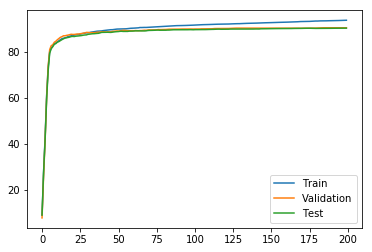

In [33]:
plot_print_accuracy(total_iter5, train_accuracy5,validation_accuracy5,test_accuracy5)

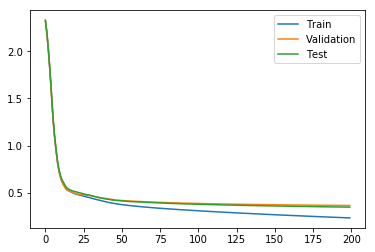

In [34]:
plot_print_loss(total_iter5, train_loss5,validation_loss5,test_loss5)

In [35]:
hiddenlayers = 100
learningrate = 0.05
momentum = 0.9
total_iter2,train_loss2,train_accuracy2,validation_loss2,validation_accuracy2,test_loss2,test_accuracy2 = model(hiddenlayers, learningrate,momentum)

Iter: 0, Train loss = 2.45233 , Train accuracy = 5.56000
Iter: 0, Validation loss = 2.45648 , Validation accuracy = 5.93333
Iter: 0, Test loss = 2.45245 , Test accuracy = 6.05727
Iter: 1, Train loss = 2.31310 , Train accuracy = 14.95000
Iter: 1, Validation loss = 2.31964 , Validation accuracy = 15.23333
Iter: 1, Test loss = 2.31225 , Test accuracy = 14.72100
Iter: 2, Train loss = 2.17030 , Train accuracy = 28.38000
Iter: 2, Validation loss = 2.17933 , Validation accuracy = 28.70000
Iter: 2, Test loss = 2.16840 , Test accuracy = 28.34068
Iter: 3, Train loss = 2.01769 , Train accuracy = 35.11000
Iter: 3, Validation loss = 2.02851 , Validation accuracy = 34.48333
Iter: 3, Test loss = 2.01664 , Test accuracy = 34.80176
Iter: 4, Train loss = 1.84718 , Train accuracy = 45.85000
Iter: 4, Validation loss = 1.85908 , Validation accuracy = 43.93333
Iter: 4, Test loss = 1.84740 , Test accuracy = 44.60352
Iter: 5, Train loss = 1.66625 , Train accuracy = 57.83000
Iter: 5, Validation loss = 1.67845 

Iter: 45, Train loss = 0.41697 , Train accuracy = 88.83000
Iter: 45, Validation loss = 0.44247 , Validation accuracy = 88.33333
Iter: 45, Test loss = 0.44951 , Test accuracy = 88.65639
Iter: 46, Train loss = 0.41378 , Train accuracy = 88.91000
Iter: 46, Validation loss = 0.44000 , Validation accuracy = 88.36667
Iter: 46, Test loss = 0.44724 , Test accuracy = 88.47283
Iter: 47, Train loss = 0.41083 , Train accuracy = 88.90000
Iter: 47, Validation loss = 0.43796 , Validation accuracy = 88.41667
Iter: 47, Test loss = 0.44486 , Test accuracy = 88.54626
Iter: 48, Train loss = 0.40788 , Train accuracy = 88.92000
Iter: 48, Validation loss = 0.43595 , Validation accuracy = 88.38333
Iter: 48, Test loss = 0.44219 , Test accuracy = 88.58297
Iter: 49, Train loss = 0.40519 , Train accuracy = 88.94000
Iter: 49, Validation loss = 0.43404 , Validation accuracy = 88.40000
Iter: 49, Test loss = 0.43966 , Test accuracy = 88.80323
Iter: 50, Train loss = 0.40267 , Train accuracy = 89.01000
Iter: 50, Valida

Iter: 90, Train loss = 0.34620 , Train accuracy = 90.41000
Iter: 90, Validation loss = 0.39633 , Validation accuracy = 89.20000
Iter: 90, Test loss = 0.40321 , Test accuracy = 89.46402
Iter: 91, Train loss = 0.34522 , Train accuracy = 90.44000
Iter: 91, Validation loss = 0.39582 , Validation accuracy = 89.21667
Iter: 91, Test loss = 0.40270 , Test accuracy = 89.46402
Iter: 92, Train loss = 0.34425 , Train accuracy = 90.48000
Iter: 92, Validation loss = 0.39531 , Validation accuracy = 89.20000
Iter: 92, Test loss = 0.40217 , Test accuracy = 89.50073
Iter: 93, Train loss = 0.34329 , Train accuracy = 90.50000
Iter: 93, Validation loss = 0.39480 , Validation accuracy = 89.20000
Iter: 93, Test loss = 0.40165 , Test accuracy = 89.50073
Iter: 94, Train loss = 0.34234 , Train accuracy = 90.51000
Iter: 94, Validation loss = 0.39430 , Validation accuracy = 89.16667
Iter: 94, Test loss = 0.40117 , Test accuracy = 89.61087
Iter: 95, Train loss = 0.34139 , Train accuracy = 90.51000
Iter: 95, Valida

Iter: 134, Train loss = 0.31009 , Train accuracy = 91.39000
Iter: 134, Validation loss = 0.37965 , Validation accuracy = 89.40000
Iter: 134, Test loss = 0.38829 , Test accuracy = 90.01468
Iter: 135, Train loss = 0.30938 , Train accuracy = 91.42000
Iter: 135, Validation loss = 0.37935 , Validation accuracy = 89.41667
Iter: 135, Test loss = 0.38804 , Test accuracy = 90.01468
Iter: 136, Train loss = 0.30868 , Train accuracy = 91.45000
Iter: 136, Validation loss = 0.37905 , Validation accuracy = 89.45000
Iter: 136, Test loss = 0.38780 , Test accuracy = 89.94126
Iter: 137, Train loss = 0.30798 , Train accuracy = 91.48000
Iter: 137, Validation loss = 0.37876 , Validation accuracy = 89.41667
Iter: 137, Test loss = 0.38758 , Test accuracy = 89.94126
Iter: 138, Train loss = 0.30728 , Train accuracy = 91.50000
Iter: 138, Validation loss = 0.37847 , Validation accuracy = 89.41667
Iter: 138, Test loss = 0.38736 , Test accuracy = 89.97797
Iter: 139, Train loss = 0.30658 , Train accuracy = 91.51000


Iter: 178, Train loss = 0.28200 , Train accuracy = 92.29000
Iter: 178, Validation loss = 0.36848 , Validation accuracy = 89.75000
Iter: 178, Test loss = 0.38031 , Test accuracy = 89.68429
Iter: 179, Train loss = 0.28142 , Train accuracy = 92.29000
Iter: 179, Validation loss = 0.36827 , Validation accuracy = 89.75000
Iter: 179, Test loss = 0.38017 , Test accuracy = 89.68429
Iter: 180, Train loss = 0.28084 , Train accuracy = 92.29000
Iter: 180, Validation loss = 0.36806 , Validation accuracy = 89.75000
Iter: 180, Test loss = 0.38004 , Test accuracy = 89.64758
Iter: 181, Train loss = 0.28026 , Train accuracy = 92.29000
Iter: 181, Validation loss = 0.36784 , Validation accuracy = 89.76667
Iter: 181, Test loss = 0.37991 , Test accuracy = 89.61087
Iter: 182, Train loss = 0.27968 , Train accuracy = 92.30000
Iter: 182, Validation loss = 0.36762 , Validation accuracy = 89.76667
Iter: 182, Test loss = 0.37979 , Test accuracy = 89.64758
Iter: 183, Train loss = 0.27910 , Train accuracy = 92.31000


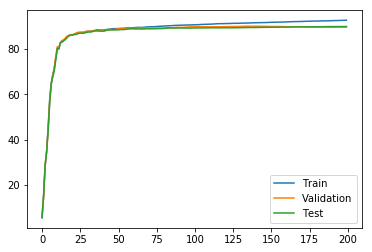

In [36]:
plot_print_accuracy(total_iter2, train_accuracy2,validation_accuracy2,test_accuracy2)

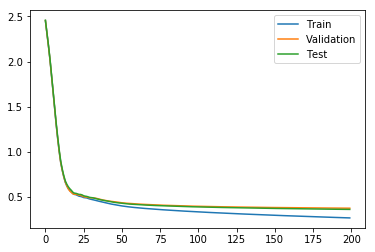

In [37]:
plot_print_loss(total_iter2, train_loss2,validation_loss2,test_loss2)

In [38]:
hiddenlayers = 500
learningrate = 0.05
momentum = 0.9
total_iter3,train_loss3,train_accuracy3,validation_loss3,validation_accuracy3,test_loss3,test_accuracy3 = model(hiddenlayers, learningrate,momentum)

Iter: 0, Train loss = 2.33029 , Train accuracy = 6.95000
Iter: 0, Validation loss = 2.33528 , Validation accuracy = 6.66667
Iter: 0, Test loss = 2.32864 , Test accuracy = 6.90162
Iter: 1, Train loss = 2.21955 , Train accuracy = 17.47000
Iter: 1, Validation loss = 2.22440 , Validation accuracy = 17.13333
Iter: 1, Test loss = 2.21783 , Test accuracy = 17.07048
Iter: 2, Train loss = 2.04351 , Train accuracy = 44.10000
Iter: 2, Validation loss = 2.04860 , Validation accuracy = 42.75000
Iter: 2, Test loss = 2.04190 , Test accuracy = 44.23642
Iter: 3, Train loss = 1.83088 , Train accuracy = 61.01000
Iter: 3, Validation loss = 1.83717 , Validation accuracy = 60.03333
Iter: 3, Test loss = 1.82985 , Test accuracy = 62.04112
Iter: 4, Train loss = 1.59650 , Train accuracy = 71.81000
Iter: 4, Validation loss = 1.60555 , Validation accuracy = 70.76667
Iter: 4, Test loss = 1.59638 , Test accuracy = 72.06314
Iter: 5, Train loss = 1.36419 , Train accuracy = 76.82000
Iter: 5, Validation loss = 1.37697 

Iter: 45, Train loss = 0.39669 , Train accuracy = 89.45000
Iter: 45, Validation loss = 0.42815 , Validation accuracy = 88.46667
Iter: 45, Test loss = 0.43136 , Test accuracy = 89.06021
Iter: 46, Train loss = 0.39399 , Train accuracy = 89.46000
Iter: 46, Validation loss = 0.42631 , Validation accuracy = 88.41667
Iter: 46, Test loss = 0.42977 , Test accuracy = 89.13363
Iter: 47, Train loss = 0.39145 , Train accuracy = 89.51000
Iter: 47, Validation loss = 0.42452 , Validation accuracy = 88.46667
Iter: 47, Test loss = 0.42832 , Test accuracy = 89.09692
Iter: 48, Train loss = 0.38904 , Train accuracy = 89.55000
Iter: 48, Validation loss = 0.42279 , Validation accuracy = 88.58333
Iter: 48, Test loss = 0.42686 , Test accuracy = 89.13363
Iter: 49, Train loss = 0.38669 , Train accuracy = 89.61000
Iter: 49, Validation loss = 0.42109 , Validation accuracy = 88.58333
Iter: 49, Test loss = 0.42530 , Test accuracy = 89.24376
Iter: 50, Train loss = 0.38452 , Train accuracy = 89.68000
Iter: 50, Valida

Iter: 89, Validation loss = 0.39117 , Validation accuracy = 89.41667
Iter: 89, Test loss = 0.39629 , Test accuracy = 89.83113
Iter: 90, Train loss = 0.33001 , Train accuracy = 91.18000
Iter: 90, Validation loss = 0.39066 , Validation accuracy = 89.41667
Iter: 90, Test loss = 0.39580 , Test accuracy = 89.83113
Iter: 91, Train loss = 0.32900 , Train accuracy = 91.18000
Iter: 91, Validation loss = 0.39016 , Validation accuracy = 89.41667
Iter: 91, Test loss = 0.39536 , Test accuracy = 89.83113
Iter: 92, Train loss = 0.32799 , Train accuracy = 91.18000
Iter: 92, Validation loss = 0.38967 , Validation accuracy = 89.46667
Iter: 92, Test loss = 0.39495 , Test accuracy = 89.86784
Iter: 93, Train loss = 0.32700 , Train accuracy = 91.21000
Iter: 93, Validation loss = 0.38920 , Validation accuracy = 89.50000
Iter: 93, Test loss = 0.39458 , Test accuracy = 89.86784
Iter: 94, Train loss = 0.32602 , Train accuracy = 91.20000
Iter: 94, Validation loss = 0.38873 , Validation accuracy = 89.50000
Iter: 

Iter: 133, Validation loss = 0.37410 , Validation accuracy = 89.75000
Iter: 133, Test loss = 0.38245 , Test accuracy = 90.19824
Iter: 134, Train loss = 0.29173 , Train accuracy = 92.14000
Iter: 134, Validation loss = 0.37376 , Validation accuracy = 89.75000
Iter: 134, Test loss = 0.38221 , Test accuracy = 90.23495
Iter: 135, Train loss = 0.29096 , Train accuracy = 92.17000
Iter: 135, Validation loss = 0.37343 , Validation accuracy = 89.76667
Iter: 135, Test loss = 0.38197 , Test accuracy = 90.23495
Iter: 136, Train loss = 0.29019 , Train accuracy = 92.18000
Iter: 136, Validation loss = 0.37309 , Validation accuracy = 89.75000
Iter: 136, Test loss = 0.38174 , Test accuracy = 90.23495
Iter: 137, Train loss = 0.28943 , Train accuracy = 92.21000
Iter: 137, Validation loss = 0.37275 , Validation accuracy = 89.76667
Iter: 137, Test loss = 0.38150 , Test accuracy = 90.23495
Iter: 138, Train loss = 0.28867 , Train accuracy = 92.23000
Iter: 138, Validation loss = 0.37242 , Validation accuracy =

Iter: 177, Train loss = 0.26101 , Train accuracy = 92.93000
Iter: 177, Validation loss = 0.36133 , Validation accuracy = 89.88333
Iter: 177, Test loss = 0.37378 , Test accuracy = 90.19824
Iter: 178, Train loss = 0.26034 , Train accuracy = 92.94000
Iter: 178, Validation loss = 0.36108 , Validation accuracy = 89.88333
Iter: 178, Test loss = 0.37362 , Test accuracy = 90.19824
Iter: 179, Train loss = 0.25968 , Train accuracy = 92.96000
Iter: 179, Validation loss = 0.36083 , Validation accuracy = 89.91667
Iter: 179, Test loss = 0.37345 , Test accuracy = 90.19824
Iter: 180, Train loss = 0.25902 , Train accuracy = 92.99000
Iter: 180, Validation loss = 0.36058 , Validation accuracy = 89.91667
Iter: 180, Test loss = 0.37329 , Test accuracy = 90.19824
Iter: 181, Train loss = 0.25837 , Train accuracy = 92.99000
Iter: 181, Validation loss = 0.36033 , Validation accuracy = 89.98333
Iter: 181, Test loss = 0.37314 , Test accuracy = 90.16153
Iter: 182, Train loss = 0.25771 , Train accuracy = 93.01000


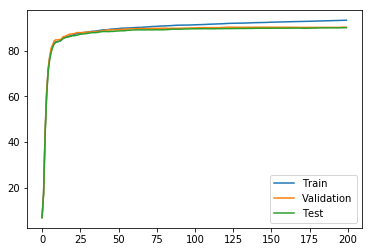

In [39]:
plot_print_accuracy(total_iter3, train_accuracy3,validation_accuracy3,test_accuracy3)

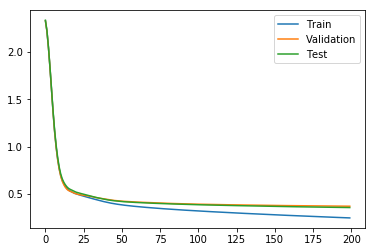

In [40]:
plot_print_loss(total_iter3, train_loss3,validation_loss3,test_loss3)

In [41]:
hiddenlayers = 2000
learningrate = 0.05
momentum = 0.9
total_iter4,train_loss4,train_accuracy4,validation_loss4,validation_accuracy4,test_loss4,test_accuracy4 = model(hiddenlayers, learningrate,momentum)

Iter: 0, Train loss = 2.36823 , Train accuracy = 6.99000
Iter: 0, Validation loss = 2.36992 , Validation accuracy = 6.56667
Iter: 0, Test loss = 2.36843 , Test accuracy = 6.49780
Iter: 1, Train loss = 2.20934 , Train accuracy = 23.60000
Iter: 1, Validation loss = 2.21345 , Validation accuracy = 22.46667
Iter: 1, Test loss = 2.20797 , Test accuracy = 23.67841
Iter: 2, Train loss = 2.01515 , Train accuracy = 34.53000
Iter: 2, Validation loss = 2.02356 , Validation accuracy = 33.90000
Iter: 2, Test loss = 2.01259 , Test accuracy = 35.13216
Iter: 3, Train loss = 1.77210 , Train accuracy = 54.37000
Iter: 3, Validation loss = 1.78444 , Validation accuracy = 53.88333
Iter: 3, Test loss = 1.76952 , Test accuracy = 55.35977
Iter: 4, Train loss = 1.48550 , Train accuracy = 77.89000
Iter: 4, Validation loss = 1.50009 , Validation accuracy = 77.60000
Iter: 4, Test loss = 1.48430 , Test accuracy = 78.63436
Iter: 5, Train loss = 1.24015 , Train accuracy = 82.41000
Iter: 5, Validation loss = 1.25528 

Iter: 44, Test loss = 0.42640 , Test accuracy = 88.95007
Iter: 45, Train loss = 0.38252 , Train accuracy = 89.72000
Iter: 45, Validation loss = 0.41674 , Validation accuracy = 88.86667
Iter: 45, Test loss = 0.42442 , Test accuracy = 89.02349
Iter: 46, Train loss = 0.37993 , Train accuracy = 89.70000
Iter: 46, Validation loss = 0.41484 , Validation accuracy = 88.95000
Iter: 46, Test loss = 0.42294 , Test accuracy = 89.09692
Iter: 47, Train loss = 0.37749 , Train accuracy = 89.68000
Iter: 47, Validation loss = 0.41322 , Validation accuracy = 89.03333
Iter: 47, Test loss = 0.42172 , Test accuracy = 89.09692
Iter: 48, Train loss = 0.37508 , Train accuracy = 89.77000
Iter: 48, Validation loss = 0.41182 , Validation accuracy = 89.06667
Iter: 48, Test loss = 0.42051 , Test accuracy = 89.31718
Iter: 49, Train loss = 0.37280 , Train accuracy = 89.89000
Iter: 49, Validation loss = 0.41062 , Validation accuracy = 89.08333
Iter: 49, Test loss = 0.41924 , Test accuracy = 89.24376
Iter: 50, Train lo

Iter: 89, Train loss = 0.31610 , Train accuracy = 91.55000
Iter: 89, Validation loss = 0.38059 , Validation accuracy = 89.65000
Iter: 89, Test loss = 0.38979 , Test accuracy = 90.12482
Iter: 90, Train loss = 0.31506 , Train accuracy = 91.58000
Iter: 90, Validation loss = 0.38012 , Validation accuracy = 89.70000
Iter: 90, Test loss = 0.38939 , Test accuracy = 90.12482
Iter: 91, Train loss = 0.31404 , Train accuracy = 91.63000
Iter: 91, Validation loss = 0.37964 , Validation accuracy = 89.71667
Iter: 91, Test loss = 0.38900 , Test accuracy = 90.12482
Iter: 92, Train loss = 0.31302 , Train accuracy = 91.65000
Iter: 92, Validation loss = 0.37916 , Validation accuracy = 89.71667
Iter: 92, Test loss = 0.38863 , Test accuracy = 90.16153
Iter: 93, Train loss = 0.31201 , Train accuracy = 91.65000
Iter: 93, Validation loss = 0.37871 , Validation accuracy = 89.71667
Iter: 93, Test loss = 0.38825 , Test accuracy = 90.16153
Iter: 94, Train loss = 0.31101 , Train accuracy = 91.68000
Iter: 94, Valida

Iter: 133, Train loss = 0.27636 , Train accuracy = 92.64000
Iter: 133, Validation loss = 0.36355 , Validation accuracy = 90.01667
Iter: 133, Test loss = 0.37656 , Test accuracy = 90.34508
Iter: 134, Train loss = 0.27555 , Train accuracy = 92.67000
Iter: 134, Validation loss = 0.36323 , Validation accuracy = 90.01667
Iter: 134, Test loss = 0.37634 , Test accuracy = 90.34508
Iter: 135, Train loss = 0.27475 , Train accuracy = 92.70000
Iter: 135, Validation loss = 0.36291 , Validation accuracy = 90.00000
Iter: 135, Test loss = 0.37612 , Test accuracy = 90.30837
Iter: 136, Train loss = 0.27396 , Train accuracy = 92.70000
Iter: 136, Validation loss = 0.36260 , Validation accuracy = 90.01667
Iter: 136, Test loss = 0.37590 , Test accuracy = 90.30837
Iter: 137, Train loss = 0.27316 , Train accuracy = 92.71000
Iter: 137, Validation loss = 0.36229 , Validation accuracy = 89.98333
Iter: 137, Test loss = 0.37569 , Test accuracy = 90.34508
Iter: 138, Train loss = 0.27237 , Train accuracy = 92.74000


Iter: 176, Test loss = 0.36864 , Test accuracy = 90.38179
Iter: 177, Train loss = 0.24354 , Train accuracy = 93.52000
Iter: 177, Validation loss = 0.35131 , Validation accuracy = 90.30000
Iter: 177, Test loss = 0.36849 , Test accuracy = 90.38179
Iter: 178, Train loss = 0.24284 , Train accuracy = 93.54000
Iter: 178, Validation loss = 0.35107 , Validation accuracy = 90.30000
Iter: 178, Test loss = 0.36833 , Test accuracy = 90.38179
Iter: 179, Train loss = 0.24215 , Train accuracy = 93.56000
Iter: 179, Validation loss = 0.35083 , Validation accuracy = 90.33333
Iter: 179, Test loss = 0.36818 , Test accuracy = 90.38179
Iter: 180, Train loss = 0.24147 , Train accuracy = 93.57000
Iter: 180, Validation loss = 0.35060 , Validation accuracy = 90.35000
Iter: 180, Test loss = 0.36802 , Test accuracy = 90.38179
Iter: 181, Train loss = 0.24078 , Train accuracy = 93.61000
Iter: 181, Validation loss = 0.35036 , Validation accuracy = 90.35000
Iter: 181, Test loss = 0.36787 , Test accuracy = 90.38179
It

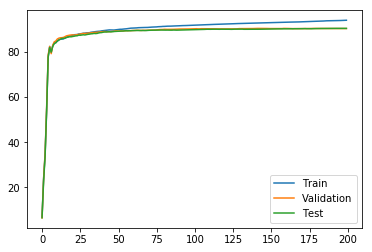

In [42]:
plot_print_accuracy(total_iter4, train_accuracy4,validation_accuracy4,test_accuracy4)

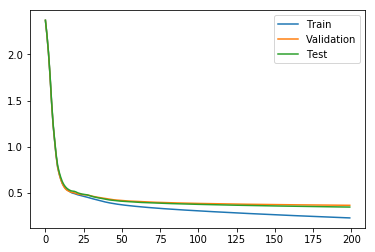

In [43]:
plot_print_loss(total_iter4, train_loss4,validation_loss4,test_loss4)